In [1]:
import glob
from tqdm import tqdm
import pickle
import os
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import matplotlib.pyplot as plt
import subprocess
paths = "/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/pickled_data/*pkl"
files = sorted(glob.glob(paths))
import sys
from genjax._src.core.pytree.utilities import *
from genjax.generative_functions.distributions import ExactDensity
import jax.tree_util as jtu
from genjax._src.core.transforms.incremental import NoChange, UnknownChange, Diff
import genjax
from tensorflow_probability.substrates import jax as tfp
sys.path.append("../")
from viz import *
from utils import *
from mcs_utils import *
console = genjax.pretty()
gt_bin = np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
paths_results = "/home/ubuntu/arijit/bayes3d/scripts/experiments/intphys/mcs/final_result_*"
files_results = glob.glob(paths_results)
files_results.sort()
for fl in files_results:
   #  if '0001' not in fl:
   #     continue
    with open(fl, 'rb') as file:
      results = pickle.load(file)
      print(f"{fl.split('/')[-1][13:]} ", results['rating'])

In [ ]:
paths = "/home/ubuntu/arijit/bayes3d/scripts/experiments/intphys/mcs/eval_7_npzs/*grav*"
files = sorted(glob.glob(paths))
print(files)
num_scenes = len(files)
for i in tqdm(range(0,num_scenes,2)):
    # file = files[i]
    scene_name_1 = files[i].split("/")[-1][:-4]
    if len(files) > i+1:
        scene_name_2 = files[i+1].split("/")[-1][:-4]
    else:
        scene_name_2 = 'exit'
    command = ["./run_mcs_full.sh", scene_name_1, scene_name_2]
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)
        # The "stdout" attribute of the result object contains the command's standard output
        print("Command Output:")
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        # If the command returns a non-zero exit code, it will raise a CalledProcessError
        print(f"Command failed with exit code {e.returncode}")
        print("Error Output:")
        print(e.stderr)

In [ ]:
paths_results = "/home/ubuntu/arijit/bayes3d/scripts/experiments/intphys/mcs/final_result_*"
files_results = glob.glob(paths_results)
files_results.sort()
for fl in files_results:
   #  if '0001' not in fl:
   #     continue

    with open(fl, 'rb') as file:
      results = pickle.load(file)
      print(f"{fl.split('/')[-1][13:]} ", results['rating'])

In [17]:
# For shape constancy only
paths_results = "/home/ubuntu/arijit/bayes3d/scripts/experiments/intphys/mcs/shape_results/*"
files_results = glob.glob(paths_results)
files_results.sort()
plaus_r = []
implaus_r = []
all_r = []
for fl in tqdm(files_results):
    with open(fl, 'rb') as file:
        results = pickle.load(file)
        all_r.append(results)
        # print(f"{fl.split('/')[-1][13:]} ", results['fracs'][98])
        # print(results["answer"], results['fracs'][98])


100%|██████████| 407/407 [00:41<00:00,  9.76it/s]


In [18]:
def threedp3_likelihood_arijit(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = (distances < variance/2) / variance
    average_probability = 1 * probabilities_per_pixel.mean()
    return average_probability


for idx,x in tqdm(enumerate(all_r)):
    gt_image = x['gt_image']
    gt_image_bg = x['gt_image_bg']
    rend = x['rendered']
    vars = []
    fracs = []
    
    for var in np.linspace(0.002,5,100):
        xx1 = threedp3_likelihood_arijit(gt_image,gt_image,var,None)
        xx2 = np.max([threedp3_likelihood_arijit(gt_image,rend[i],var,None) for i in range(3)])
        xx3 = threedp3_likelihood_arijit(gt_image,gt_image_bg,var,None)
        frac = (xx2-xx3)/(xx1-xx3)
        vars.append(var)
        fracs.append(frac)

    x['fracs'] = fracs
    x['vars'] = vars
    all_r[idx] = x


for results in all_r:
    if results['answer'] == 'plausible':# and results[num_objects'] == 1 and result['va']:
        plaus_r.append(results)
    elif results['answer'] == 'implausible':# and results['num_objects'] == 1:
        implaus_r.append(results)

407it [04:49,  1.41it/s]


  6%|▌         | 6/100 [00:00<00:03, 24.91it/s]

var = {} 0.002
optimal_threshold =  -0.3536553
Implaus: 34/137
plaus: 73/80
Percentage :  58.033759124087595 %
------------------------------
var = {} 0.05248484848484849
optimal_threshold =  0.2222256
Implaus: 104/137
plaus: 62/80
Percentage :  76.70620437956204 %
------------------------------
var = {} 0.10296969696969697
optimal_threshold =  0.44444793
Implaus: 102/137
plaus: 62/80
Percentage :  75.97627737226279 %
------------------------------
var = {} 0.15345454545454545
optimal_threshold =  0.5636367
Implaus: 110/137
plaus: 57/80
Percentage :  75.77098540145985 %
------------------------------
var = {} 0.20393939393939395
optimal_threshold =  0.606382
Implaus: 107/137
plaus: 57/80
Percentage :  74.67609489051095 %
------------------------------
var = {} 0.25442424242424244
optimal_threshold =  0.6042731
Implaus: 99/137
plaus: 61/80
Percentage :  74.25638686131386 %
------------------------------


 12%|█▏        | 12/100 [00:00<00:03, 25.24it/s]

var = {} 0.3049090909090909
optimal_threshold =  0.6164414
Implaus: 97/137
plaus: 63/80
Percentage :  74.7764598540146 %
------------------------------
var = {} 0.35539393939393943
optimal_threshold =  0.6049398
Implaus: 86/137
plaus: 69/80
Percentage :  74.51186131386862 %
------------------------------
var = {} 0.4058787878787879
optimal_threshold =  0.6111076
Implaus: 84/137
plaus: 69/80
Percentage :  73.78193430656934 %
------------------------------
var = {} 0.45636363636363636
optimal_threshold =  0.72727084
Implaus: 115/137
plaus: 51/80
Percentage :  73.84580291970802 %
------------------------------
var = {} 0.5068484848484849
optimal_threshold =  0.73612934
Implaus: 115/137
plaus: 51/80
Percentage :  73.84580291970802 %
------------------------------
var = {} 0.5573333333333333
optimal_threshold =  0.67032534
Implaus: 90/137
plaus: 67/80
Percentage :  74.72171532846716 %
------------------------------


 18%|█▊        | 18/100 [00:00<00:03, 25.25it/s]

var = {} 0.6078181818181818
optimal_threshold =  0.69343096
Implaus: 95/137
plaus: 64/80
Percentage :  74.67153284671532 %
------------------------------
var = {} 0.6583030303030303
optimal_threshold =  0.6923115
Implaus: 94/137
plaus: 67/80
Percentage :  76.1815693430657 %
------------------------------
var = {} 0.7087878787878789
optimal_threshold =  0.70987236
Implaus: 97/137
plaus: 65/80
Percentage :  76.02645985401459 %
------------------------------
var = {} 0.7592727272727273
optimal_threshold =  0.70803654
Implaus: 97/137
plaus: 67/80
Percentage :  77.2764598540146 %
------------------------------
var = {} 0.8097575757575758
optimal_threshold =  0.7076076
Implaus: 97/137
plaus: 68/80
Percentage :  77.9014598540146 %
------------------------------
var = {} 0.8602424242424243
optimal_threshold =  0.70329744
Implaus: 93/137
plaus: 70/80
Percentage :  77.69160583941606 %
------------------------------


 21%|██        | 21/100 [00:00<00:03, 25.13it/s]

var = {} 0.9107272727272727
optimal_threshold =  0.70760477
Implaus: 93/137
plaus: 70/80
Percentage :  77.69160583941606 %
------------------------------
var = {} 0.9612121212121213
optimal_threshold =  0.7345692
Implaus: 99/137
plaus: 66/80
Percentage :  77.38138686131386 %
------------------------------
var = {} 1.0116969696969698
optimal_threshold =  0.72222495
Implaus: 95/137
plaus: 69/80
Percentage :  77.79653284671532 %
------------------------------
var = {} 1.0621818181818181
optimal_threshold =  0.7291686
Implaus: 98/137
plaus: 68/80
Percentage :  78.26642335766422 %
------------------------------
var = {} 1.1126666666666667
optimal_threshold =  0.7356337
Implaus: 94/137
plaus: 68/80
Percentage :  76.80656934306569 %
------------------------------


 27%|██▋       | 27/100 [00:01<00:02, 24.49it/s]

var = {} 1.1631515151515153
optimal_threshold =  0.73611575
Implaus: 94/137
plaus: 68/80
Percentage :  76.80656934306569 %
------------------------------
var = {} 1.2136363636363636
optimal_threshold =  0.73610985
Implaus: 94/137
plaus: 68/80
Percentage :  76.80656934306569 %
------------------------------
var = {} 1.2641212121212122
optimal_threshold =  0.74545115
Implaus: 96/137
plaus: 67/80
Percentage :  76.91149635036496 %
------------------------------
var = {} 1.3146060606060606
optimal_threshold =  0.7430589
Implaus: 94/137
plaus: 68/80
Percentage :  76.80656934306569 %
------------------------------
var = {} 1.3650909090909091
optimal_threshold =  0.752872
Implaus: 98/137
plaus: 67/80
Percentage :  77.64142335766424 %
------------------------------
var = {} 1.4155757575757577
optimal_threshold =  0.7528804
Implaus: 98/137
plaus: 67/80
Percentage :  77.64142335766424 %
------------------------------


 33%|███▎      | 33/100 [00:01<00:02, 24.87it/s]

var = {} 1.466060606060606
optimal_threshold =  0.75287104
Implaus: 98/137
plaus: 67/80
Percentage :  77.64142335766424 %
------------------------------
var = {} 1.5165454545454546
optimal_threshold =  0.7528739
Implaus: 97/137
plaus: 67/80
Percentage :  77.2764598540146 %
------------------------------
var = {} 1.567030303030303
optimal_threshold =  0.7528717
Implaus: 96/137
plaus: 67/80
Percentage :  76.91149635036496 %
------------------------------
var = {} 1.6175151515151516
optimal_threshold =  0.7346908
Implaus: 89/137
plaus: 70/80
Percentage :  76.23175182481752 %
------------------------------
var = {} 1.6680000000000001
optimal_threshold =  0.75823987
Implaus: 94/137
plaus: 67/80
Percentage :  76.1815693430657 %
------------------------------
var = {} 1.7184848484848485
optimal_threshold =  0.76373273
Implaus: 96/137
plaus: 66/80
Percentage :  76.28649635036496 %
------------------------------


 39%|███▉      | 39/100 [00:01<00:02, 25.52it/s]

var = {} 1.768969696969697
optimal_threshold =  0.76811534
Implaus: 98/137
plaus: 66/80
Percentage :  77.01642335766424 %
------------------------------
var = {} 1.8194545454545454
optimal_threshold =  0.7681119
Implaus: 96/137
plaus: 67/80
Percentage :  76.91149635036496 %
------------------------------
var = {} 1.869939393939394
optimal_threshold =  0.7681066
Implaus: 96/137
plaus: 67/80
Percentage :  76.91149635036496 %
------------------------------
var = {} 1.9204242424242426
optimal_threshold =  0.76811165
Implaus: 96/137
plaus: 67/80
Percentage :  76.91149635036496 %
------------------------------
var = {} 1.970909090909091
optimal_threshold =  0.7681137
Implaus: 96/137
plaus: 67/80
Percentage :  76.91149635036496 %
------------------------------
var = {} 2.0213939393939393
optimal_threshold =  0.76811665
Implaus: 96/137
plaus: 67/80
Percentage :  76.91149635036496 %
------------------------------


 45%|████▌     | 45/100 [00:01<00:02, 25.66it/s]

var = {} 2.071878787878788
optimal_threshold =  0.7681202
Implaus: 94/137
plaus: 67/80
Percentage :  76.1815693430657 %
------------------------------
var = {} 2.122363636363636
optimal_threshold =  0.7681151
Implaus: 93/137
plaus: 67/80
Percentage :  75.81660583941606 %
------------------------------
var = {} 2.1728484848484846
optimal_threshold =  0.7681226
Implaus: 92/137
plaus: 67/80
Percentage :  75.45164233576642 %
------------------------------
var = {} 2.223333333333333
optimal_threshold =  0.7938239
Implaus: 100/137
plaus: 62/80
Percentage :  75.2463503649635 %
------------------------------
var = {} 2.2738181818181817
optimal_threshold =  0.7938097
Implaus: 100/137
plaus: 62/80
Percentage :  75.2463503649635 %
------------------------------
var = {} 2.3243030303030303
optimal_threshold =  0.790909
Implaus: 100/137
plaus: 63/80
Percentage :  75.8713503649635 %
------------------------------


 52%|█████▏    | 52/100 [00:02<00:01, 26.92it/s]

var = {} 2.3747878787878784
optimal_threshold =  0.79090667
Implaus: 100/137
plaus: 63/80
Percentage :  75.8713503649635 %
------------------------------
var = {} 2.425272727272727
optimal_threshold =  0.8041275
Implaus: 100/137
plaus: 62/80
Percentage :  75.2463503649635 %
------------------------------
var = {} 2.4757575757575756
optimal_threshold =  0.8135613
Implaus: 104/137
plaus: 61/80
Percentage :  76.08120437956204 %
------------------------------
var = {} 2.526242424242424
optimal_threshold =  0.8135524
Implaus: 102/137
plaus: 61/80
Percentage :  75.35127737226277 %
------------------------------
var = {} 2.5767272727272728
optimal_threshold =  0.8135621
Implaus: 102/137
plaus: 62/80
Percentage :  75.97627737226279 %
------------------------------
var = {} 2.627212121212121
optimal_threshold =  0.8135526
Implaus: 102/137
plaus: 62/80
Percentage :  75.97627737226279 %
------------------------------


 58%|█████▊    | 58/100 [00:02<00:01, 27.55it/s]

var = {} 2.6776969696969695
optimal_threshold =  0.8194461
Implaus: 103/137
plaus: 61/80
Percentage :  75.7162408759124 %
------------------------------
var = {} 2.728181818181818
optimal_threshold =  0.81944627
Implaus: 102/137
plaus: 61/80
Percentage :  75.35127737226277 %
------------------------------
var = {} 2.7786666666666666
optimal_threshold =  0.81943953
Implaus: 102/137
plaus: 61/80
Percentage :  75.35127737226277 %
------------------------------
var = {} 2.829151515151515
optimal_threshold =  0.8194307
Implaus: 102/137
plaus: 61/80
Percentage :  75.35127737226277 %
------------------------------
var = {} 2.8796363636363633
optimal_threshold =  0.82475203
Implaus: 103/137
plaus: 60/80
Percentage :  75.09124087591242 %
------------------------------
var = {} 2.930121212121212
optimal_threshold =  0.8194467
Implaus: 101/137
plaus: 62/80
Percentage :  75.61131386861314 %
------------------------------


 64%|██████▍   | 64/100 [00:02<00:01, 27.98it/s]

var = {} 2.9806060606060605
optimal_threshold =  0.8194523
Implaus: 100/137
plaus: 62/80
Percentage :  75.2463503649635 %
------------------------------
var = {} 3.031090909090909
optimal_threshold =  0.81944203
Implaus: 98/137
plaus: 62/80
Percentage :  74.51642335766424 %
------------------------------
var = {} 3.0815757575757576
optimal_threshold =  0.8297864
Implaus: 99/137
plaus: 60/80
Percentage :  73.63138686131387 %
------------------------------
var = {} 3.1320606060606058
optimal_threshold =  0.8297903
Implaus: 99/137
plaus: 60/80
Percentage :  73.63138686131387 %
------------------------------
var = {} 3.1825454545454543
optimal_threshold =  0.829788
Implaus: 98/137
plaus: 60/80
Percentage :  73.26642335766424 %
------------------------------
var = {} 3.233030303030303
optimal_threshold =  0.78948206
Implaus: 84/137
plaus: 68/80
Percentage :  73.15693430656934 %
------------------------------


 70%|███████   | 70/100 [00:02<00:01, 28.04it/s]

var = {} 3.2835151515151515
optimal_threshold =  0.82183987
Implaus: 95/137
plaus: 62/80
Percentage :  73.42153284671534 %
------------------------------
var = {} 3.334
optimal_threshold =  0.82978684
Implaus: 97/137
plaus: 62/80
Percentage :  74.1514598540146 %
------------------------------
var = {} 3.384484848484848
optimal_threshold =  0.82979316
Implaus: 96/137
plaus: 62/80
Percentage :  73.78649635036496 %
------------------------------
var = {} 3.434969696969697
optimal_threshold =  0.8297857
Implaus: 96/137
plaus: 62/80
Percentage :  73.78649635036496 %
------------------------------
var = {} 3.4854545454545454
optimal_threshold =  0.82978654
Implaus: 96/137
plaus: 62/80
Percentage :  73.78649635036496 %
------------------------------
var = {} 3.535939393939394
optimal_threshold =  0.8297854
Implaus: 96/137
plaus: 62/80
Percentage :  73.78649635036496 %
------------------------------


 76%|███████▌  | 76/100 [00:02<00:00, 27.53it/s]

var = {} 3.5864242424242425
optimal_threshold =  0.82980025
Implaus: 96/137
plaus: 62/80
Percentage :  73.78649635036496 %
------------------------------
var = {} 3.6369090909090906
optimal_threshold =  0.8297856
Implaus: 95/137
plaus: 62/80
Percentage :  73.42153284671534 %
------------------------------
var = {} 3.6873939393939392
optimal_threshold =  0.8297906
Implaus: 94/137
plaus: 62/80
Percentage :  73.0565693430657 %
------------------------------
var = {} 3.737878787878788
optimal_threshold =  0.8289501
Implaus: 92/137
plaus: 63/80
Percentage :  72.95164233576642 %
------------------------------
var = {} 3.7883636363636364
optimal_threshold =  0.8359946
Implaus: 94/137
plaus: 62/80
Percentage :  73.0565693430657 %
------------------------------
var = {} 3.838848484848485
optimal_threshold =  0.83600074
Implaus: 94/137
plaus: 62/80
Percentage :  73.0565693430657 %
------------------------------


 82%|████████▏ | 82/100 [00:03<00:00, 26.75it/s]

var = {} 3.889333333333333
optimal_threshold =  0.8360032
Implaus: 93/137
plaus: 62/80
Percentage :  72.69160583941606 %
------------------------------
var = {} 3.9398181818181817
optimal_threshold =  0.8389932
Implaus: 93/137
plaus: 61/80
Percentage :  72.06660583941606 %
------------------------------
var = {} 3.9903030303030302
optimal_threshold =  0.81884104
Implaus: 86/137
plaus: 65/80
Percentage :  72.01186131386861 %
------------------------------
var = {} 4.040787878787879
optimal_threshold =  0.8360008
Implaus: 89/137
plaus: 63/80
Percentage :  71.85675182481752 %
------------------------------
var = {} 4.091272727272727
optimal_threshold =  0.8359959
Implaus: 88/137
plaus: 63/80
Percentage :  71.49178832116789 %
------------------------------
var = {} 4.141757575757576
optimal_threshold =  0.83332926
Implaus: 88/137
plaus: 64/80
Percentage :  72.11678832116787 %
------------------------------


 88%|████████▊ | 88/100 [00:03<00:00, 27.01it/s]

var = {} 4.1922424242424245
optimal_threshold =  0.8333403
Implaus: 88/137
plaus: 64/80
Percentage :  72.11678832116787 %
------------------------------
var = {} 4.242727272727272
optimal_threshold =  0.83333194
Implaus: 87/137
plaus: 64/80
Percentage :  71.75182481751825 %
------------------------------
var = {} 4.293212121212121
optimal_threshold =  0.8333433
Implaus: 88/137
plaus: 64/80
Percentage :  72.11678832116787 %
------------------------------
var = {} 4.343696969696969
optimal_threshold =  0.833342
Implaus: 87/137
plaus: 64/80
Percentage :  71.75182481751825 %
------------------------------
var = {} 4.394181818181818
optimal_threshold =  0.83333474
Implaus: 88/137
plaus: 64/80
Percentage :  72.11678832116787 %
------------------------------
var = {} 4.4446666666666665
optimal_threshold =  0.83332896
Implaus: 88/137
plaus: 64/80
Percentage :  72.11678832116787 %
------------------------------


 95%|█████████▌| 95/100 [00:03<00:00, 28.51it/s]

var = {} 4.495151515151515
optimal_threshold =  0.83333635
Implaus: 88/137
plaus: 64/80
Percentage :  72.11678832116787 %
------------------------------
var = {} 4.545636363636364
optimal_threshold =  0.83334386
Implaus: 87/137
plaus: 64/80
Percentage :  71.75182481751825 %
------------------------------
var = {} 4.596121212121212
optimal_threshold =  0.8333394
Implaus: 87/137
plaus: 64/80
Percentage :  71.75182481751825 %
------------------------------
var = {} 4.646606060606061
optimal_threshold =  0.79166996
Implaus: 72/137
plaus: 72/80
Percentage :  71.27737226277372 %
------------------------------
var = {} 4.697090909090909
optimal_threshold =  0.7916616
Implaus: 72/137
plaus: 72/80
Percentage :  71.27737226277372 %
------------------------------
var = {} 4.747575757575757
optimal_threshold =  0.8011724
Implaus: 73/137
plaus: 71/80
Percentage :  71.01733576642334 %
------------------------------
var = {} 4.798060606060606
optimal_threshold =  0.8011697
Implaus: 73/137
plaus: 71/8

100%|██████████| 100/100 [00:03<00:00, 26.45it/s]

var = {} 4.848545454545454
optimal_threshold =  0.8011706
Implaus: 73/137
plaus: 71/80
Percentage :  71.01733576642334 %
------------------------------
var = {} 4.899030303030303
optimal_threshold =  0.8011738
Implaus: 73/137
plaus: 71/80
Percentage :  71.01733576642334 %
------------------------------
var = {} 4.949515151515151
optimal_threshold =  0.80198115
Implaus: 72/137
plaus: 72/80
Percentage :  71.27737226277372 %
------------------------------
var = {} 5.0
optimal_threshold =  0.8019801
Implaus: 71/137
plaus: 72/80
Percentage :  70.91240875912409 %
------------------------------


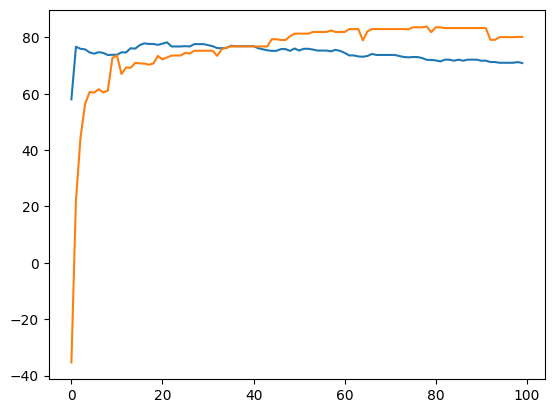

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

percs = []
threshes = []
for i in tqdm(range(len(implaus_r[0]['fracs']))):
    implaus = []
    plaus = []
    for x in implaus_r:
        # implaus.append(x['fracs'][i])
        if x['plausibility'] and x['num_objects'] == 2:
            implaus.append(x['fracs'][i])
        # elif not x['plausibility'] and x['num_objects'] == 2:
        #     implaus.append(0)
        # if x['num_objects'] == 1:
        #     implaus.append(x['fracs'][i])
    for x in plaus_r:
        # plaus.append(x['fracs'][i])
        if x['plausibility'] and x['num_objects'] == 2:
            plaus.append(x['fracs'][i])
        # elif not x['plausibility'] and x['num_objects'] == 2:
        #     plaus.append(0)
        # if x['num_objects'] == 1:
        #     plaus.append(x['fracs'][i])

    implaus = np.array(implaus)
    plaus = np.array(plaus)

    all_scores = np.concatenate((implaus, plaus))
    labels = np.concatenate((np.zeros(len(implaus)), np.ones(len(plaus))))
    correction_factor = len(implaus)/len(plaus)
    sample_weights = np.concatenate((np.ones(len(implaus)), np.ones(len(plaus))*correction_factor))
    fpr, tpr, thresholds = roc_curve(labels, all_scores, sample_weight=sample_weights)
    opt_t = thresholds[np.argmax(tpr - fpr)]
    threshes.append(opt_t)
    imp_score = np.sum(implaus < opt_t)
    imp_total = implaus.shape[0]
    pl_score = np.sum(plaus >= opt_t)
    pl_total = plaus.shape[0]
    perc = 100 * ((imp_score/imp_total) + (pl_score/pl_total)) * 0.5
    percs.append(perc)
    print("var = {}", implaus_r[0]['vars'][i])
    print("optimal_threshold = ", opt_t)
    print(f"Implaus: {imp_score}/{imp_total}")
    print(f"plaus: {pl_score}/{pl_total}")
    print("Percentage : ", perc, "%")
    print("------------------------------")
    # plt.figure(figsize=(8, 6))
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate (FPR)')
    # plt.ylabel('True Positive Rate (TPR)')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    # plt.legend(loc='lower right')
    # plt.show()
plt.plot(percs)
plt.plot(np.array(threshes)*100)

In [23]:
display(np.max(percs))
implaus_r[0]['vars'][np.argmax(percs)]

78.26642335766422

1.0621818181818181

In [24]:
threshes[np.argmax(percs)]

0.7291686

In [73]:
import random 
def threedp3_likelihood_arijit(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = (distances < variance/2) / variance
    average_probability = 1 * probabilities_per_pixel.mean()
    return average_probability

def outlier_gaussian(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = jax.scipy.stats.norm.pdf(
        distances,
        loc=0.0, 
        scale=variance
    )
    average_probability = 0.01 * probabilities_per_pixel.sum()
    return average_probability


def determine_shape_constancy_plausibility(num_objects, last_gt_image, last_gt_image_bg, last_rend):
    # if not plausibility:
    #     return 0
    best_p_index = np.argmax([outlier_gaussian(last_gt_image, last_rend[i], 0.5, None) for i in range(3)])
    # best_p_index = np.argmax([threedp3_likelihood_arijit(last_gt_image, last_rend[i], 0.5, None) for i in range(3)])
    if num_objects == 2:
        # var = 0.108
        var = 1.0621818181818181
        xx1 = threedp3_likelihood_arijit(last_gt_image,last_gt_image,var,None)
        xx2 = threedp3_likelihood_arijit(last_gt_image,last_rend[best_p_index],var,None)
        xx3 = threedp3_likelihood_arijit(last_gt_image,last_gt_image_bg,var,None)
        frac = (xx2-xx3)/(xx1-xx3)
        if frac < 0.7291686:
        # if frac < 0.38143346:
            return 0
        else:
            return 1
    elif num_objects == 1:
        var = 1.415
        # var = 0.115
        xx1 = threedp3_likelihood_arijit(last_gt_image,last_gt_image,var,None)
        xx2 = threedp3_likelihood_arijit(last_gt_image,last_rend[best_p_index],var,None)
        xx3 = threedp3_likelihood_arijit(last_gt_image,last_gt_image_bg,var,None)
        frac = (xx2-xx3)/(xx1-xx3)
        # if frac < 0.4827912:
        if frac < 0.74286604:
            return 0
        else:
            return 1
    else:
        return np.random.choice([0,1])
    # xx1 = threedp3_likelihood_arijit(last_gt_image,last_gt_image,0.108,None)
    # xx2 = threedp3_likelihood_arijit(last_gt_image,last_rend[best_p_index],0.108,None)
    # xx3 = threedp3_likelihood_arijit(last_gt_image,last_gt_image_bg,0.108,None)
    # frac = (xx2-xx3)/(xx1-xx3)
    # if frac < 0.38405928:
    #     return 0
    # else:
    #     return 1

In [74]:
convert_dict = {'plausible':1,'implausible':0}
imp_count = 0
imp_total = 0
pl_count = 0
pl_total = 0
sampled_r = random.sample(all_r,407)
for r in tqdm(sampled_r):
    pred = determine_shape_constancy_plausibility(r['num_objects'], r['gt_image'], r['gt_image_bg'], r['rendered'], r['plausibility'])
    if convert_dict[r['answer']] == 1:
        pl_total += 1
        if pred == convert_dict[r['answer']]:
            pl_count+=1
    else:
        imp_total += 1
        if pred == convert_dict[r['answer']]:
            imp_count +=1

print("Implausible Score: {}/{}".format(imp_count,imp_total))
print("Implausible Perc: {}%".format(100*imp_count/imp_total))
print("Plausible Score: {}/{}".format(pl_count,pl_total))
print("Plausible Perc: {}%".format(100*pl_count/pl_total))
print("Non-weighted Score : {}/{}".format(imp_count+pl_count,imp_total+pl_total))
print("Non-weighted Perc : {}%".format(100*(imp_count+pl_count)/(imp_total+pl_total)))
print("Weighted Perc : {}%".format((100*imp_count/imp_total + 100*pl_count/pl_total)*0.5))

100%|██████████| 407/407 [00:06<00:00, 62.07it/s]

Implausible Score: 187/245
Implausible Perc: 76.3265306122449%
Plausible Score: 134/162
Plausible Perc: 82.71604938271605%
Non-weighted Score : 321/407
Non-weighted Perc : 78.86977886977887%
Weighted Perc : 79.52128999748047%


In [ ]:
all_r[0]

In [ ]:
testing_files = files[:]
# testing_files.remove(testing_files[5])
for file in tqdm(testing_files):
    scene_name = file.split("/")[-1][:-4]
    print(scene_name)
    # with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_4/results_{scene_name}.pkl", 'rb') as file:
    #     results = pickle.load(file)
    # print(scene_name)
    # display(display_video(results["viz"]))

In [ ]:
def load_path(scene_name):
    with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_4/results_{scene_name}.pkl", 'rb') as file:
        return pickle.load(file)

In [ ]:
with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_5/results_passive_physics_validation_shape_constancy_0001_05.pkl", 'rb') as file:
    results = pickle.load(file)
display_video(results["viz"])

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


all_fracs = []


    

In [ ]:
opt_t

In [ ]:
import csv

# Replace 'yourfile.csv' with the path to your CSV file
# Replace new_data list with the values you want to add
new_data = ['value1', 'value2', 'value3']

with open('yourfile.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(new_data)

In [ ]:
observations = np.load("eval_7_npzs/{}.npz".format("eval_7_passive_physics_gravity_support_0004_27_debug"),allow_pickle=True)["arr_0"]
SCALE =0.2
preprocessed_data = preprocess_mcs_physics_scene(observations, MIN_DIST_THRESH=0.6, scale=SCALE)
# with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/pickled_data/{scene_ID}.pkl", 'rb') as file:
#     preprocessed_data = pickle.load(file)

(gt_images, gt_images_bg, gt_images_obj, intrinsics),\
(gt_images_orig, gt_images_bg_orig, gt_images_obj_orig, intrinsics_orig),\
registered_objects, obj_pixels, is_gravity, poses, cam_pose = preprocessed_data

print("Gravity?: ", is_gravity)
if is_gravity:
    plausible, plausibility_list, _ = gravity_scene_plausible(poses, intrinsics_orig, cam_pose, observations)
    display(plausible)

In [ ]:
b.get_depth_image(gt_images_obj_orig[33,...,2])

In [ ]:
registered_objects

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: this is code used to check if resampling happened
n_particles = results['resampled_indices'].shape[1]
jnp.all(results['resampled_indices'] == np.arange(n_particles), axis = 1)

base_indices = np.arange(n_particles)
for i in range(results['resampled_indices'].shape[0]):
    base_indices = base_indices[results['resampled_indices'][i]]

max_rend_ll = 9600*jax.scipy.stats.norm.pdf(
        0.,
        loc=0.0, 
        scale=0.1
    ) * 0.01
offst = 3
# scene = implausible_perm_results[3]
scene = results# implausible_perm_results[3]

worst_rend = scene["worst_rend"]

data = scene["phy_ll"][0][offst:]

fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust figsize as needed

# Set global min and max for y-axis
ymin, ymax = np.min(data), np.max(data)

for i in range(30):
    ax = axes[i//5, i%5]
    ax.plot(data[:, base_indices[i]])
    ax.set_ylim([-4.66, -4.57])  # Set the same y-axis limits for all plots
    ax.set_title(f"Particle {i+1}")
    # ax.set_yscale("log")

plt.tight_layout()
plt.show()


data = scene["rend_ll"][offst:]

fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust figsize as needed

# Set global min and max for y-axis
ymin, ymax = np.min(data), np.max(data)

for i in range(30):
    ax = axes[i//5, i%5]
    ax.plot(data[:, base_indices[i]])
    ax.plot(worst_rend[offst:], linestyle="--")
    ax.set_ylim([worst_rend[offst:].min(),max_rend_ll + 0.1*(max_rend_ll - worst_rend[offst:].min())])
    ax.set_title(f"Particle {i+1}")
    # ax.set_yscale("log")



plt.tight_layout()
plt.show()

In [ ]:
# TODO: this is code used to check if resampling happened
n_particles = results['resampled_indices'].shape[1]
resampled_bool = jnp.all(results['resampled_indices'] == np.arange(n_particles), axis = 1)

base_indices = np.arange(n_particles)
for i in range(results['resampled_indices'].shape[0]):
    base_indices = base_indices[results['resampled_indices'][i]]

In [ ]:
resampled_bool

In [ ]:
def load_path(scene_name):
    with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_5/results_{scene_name}.pkl", 'rb') as file:
        return pickle.load(file)

plausible_scenes = [files[i].split("/")[-1][:-4] for i in range(62) if gt_bin[i] == 1]
implausible_scenes = [files[i].split("/")[-1][:-4] for i in range(62) if gt_bin[i] == 0]

plausible_scenes_perm = [x for x in plausible_scenes if "permanence" in x]
implausible_scenes_perm = [x for x in implausible_scenes if "permanence" in x]

plausible_perm_results = [determine_plausibility(load_path(x))[0] for x in plausible_scenes_perm]
implausible_perm_results = [determine_plausibility(load_path(x))[0] for x in implausible_scenes_perm]

plausible_scenes_shape = [x for x in plausible_scenes if "shape" in x]
implausible_scenes_shape = [x for x in implausible_scenes if "shape" in x]

plausible_shape_results = [determine_plausibility(load_path(x),3,0.75)[0] for x in plausible_scenes_shape]
implausible_shape_results = [determine_plausibility(load_path(x),3,0.75)[0] for x in implausible_scenes_shape]

plausible_scenes_cont = [x for x in plausible_scenes if "continuity" in x]
implausible_scenes_cont = [x for x in implausible_scenes if "continuity" in x]

plausible_cont_results = [determine_plausibility(load_path(x))[0] for x in plausible_scenes_cont]
implausible_cont_results = [determine_plausibility(load_path(x))[0] for x in implausible_scenes_cont]

In [ ]:
display(implausible_cont_results)
display(implausible_perm_results)
display(implausible_shape_results)
display(plausible_cont_results)
display(plausible_perm_results)
display(plausible_shape_results)

In [ ]:
for x in plausible_scenes_perm:
    print(x, determine_plausibility(load_path(x))[3])
for x in implausible_scenes_perm:
    print(x, determine_plausibility(load_path(x))[3])

for x in plausible_scenes_cont:
    print(x, determine_plausibility(load_path(x))[3])
for x in implausible_scenes_cont:
    print(x, determine_plausibility(load_path(x))[3])

for x in plausible_scenes_shape:
    print(x, determine_plausibility(load_path(x))[3])
for x in implausible_scenes_shape:
    print(x, determine_plausibility(load_path(x))[3])

In [ ]:
plausible_rend_markers = [np.min(np.max(x["rend_ll"][3:,:],axis=1)) for x in plausible_perm_results]
implausible_rend_markers = [np.min(np.max(x["rend_ll"][3:,:],axis=1)) for x in implausible_perm_results]

In [ ]:
plausible_rend_markers

In [ ]:
implausible_rend_markers

In [ ]:
plausible_phy_markers = [np.min(np.median(x["phy_ll"][0][3:,:],axis=1)) for x in plausible_perm_results]
implausible_phy_markers = [np.min(np.median(x["phy_ll"][0][3:,:],axis=1)) for x in implausible_perm_results]

In [ ]:
plausible_phy_markers, plausible_scenes_perm

In [ ]:
implausible_phy_markers, implausible_scenes_perm

In [ ]:
# Create a scatter plot for the first cluster (in blue)
plt.scatter(plausible_phy_markers, plausible_rend_markers, c='blue', label='Plausible')

# Create a scatter plot for the second cluster (in red)
plt.scatter(implausible_phy_markers, implausible_rend_markers, c='red', label='Implausible')

# Add labels and a title
plt.xlabel('Physics LL')
plt.ylabel('Rend LL')
plt.title('Cluster Plot')

# Add a legend to distinguish between clusters
plt.legend()

# Display the plot
plt.show()

In [ ]:
implausible_scenes_perm

In [ ]:
params = (jnp.array([1e-0,1e-0,5e-1]), 5e-1)
# params = (1e+20, 0)
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0,0,0]), *params))
# display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.005,0.0,0.0]), *params))
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.0,1,0.0]), *params))
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.0,0.0,1]), *params))
# 0.02 ll diff for movement of away

In [ ]:
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([1,0,0]), *(5e-0,5e-1)))

In [ ]:
params = [1,1,1]
display(genjax.tfp_mv_normal_diag.logpdf([0,0,0],[0,0,0],params))
display(genjax.tfp_mv_normal_diag.logpdf([0.1,0.1,0.0],[0,0,0],params))
display(genjax.tfp_mv_normal_diag.logpdf([0.0,0.1,0.1],[0,0,0],params))


In [ ]:
qs = jnp.linspace(0.05,0.95,30)
tfp.distributions.Normal(0.02,0.05).quantile(qs)

In [ ]:
display(9600*jax.scipy.stats.norm.pdf(
        np.array([0.]),
        loc=0.0, 
        scale=0.1
    ) * 0.01)

9600*jax.scipy.stats.norm.pdf(
        np.array([0.0001]),
        loc=0.0, 
        scale=0.1
    ) * 0.01



In [ ]:
3.9894223 * (2400-6) *0.01
